In [2]:
import abcd_graph
from umap import UMAP
import scipy.sparse as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from partition_sknetwork import ECG
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

import os
import subprocess

from cove import COVE
from cove.dimension_reduction import LaplacianEigenmap, UMAPLE
from utils import *

# UMAP throws a warning when fitting with a randomstate
import warnings
warnings.filterwarnings('ignore')

In [2]:
## path to julia
julia = '~/.juliaup/bin/julia'
#julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ' ## you may need the full path here

## location of the CGE Julia script (Comparing Graph Embeddings framework)
cge = 'CGE_CLI.jl '

In [3]:
# To use existing embeddings, run store_embeddings.py and load the files

# To generate each embedding as needed, comment out loading the files and uncomment
# the embedding step. Warning that this is fairly slow for the larger graphs.

graphs = ["football", "primary1", "primary2", "eu-core", "eurosis", "cora_small", "airport", "blogcatalog", "cora", "as"]
RUNS = 10

dim=2
n_walks = 10
walk_len = 40
window_size=7
vectorizer = COVE(window_length=window_size, walks_per_node = n_walks, walk_length = walk_len)

svd = TruncatedSVD(n_components=dim)
umap = UMAP(n_components=dim, metric="hellinger")
umaple = UMAPLE(dimension=dim, metric="hellinger")

ecg = ECG()

data = []
random_state = np.random.RandomState(42)
for i, graph in enumerate(graphs):
    print(graph)
    adjacency, labels = load_graph(graph)
    labels = ecg.fit_predict(adjacency)

    with tqdm(total=RUNS*5) as pbar:
        for run in range(RUNS):
            #high = vectorizer.fit(adjacency).cooccurance_csr_
            high = sp.load_npz(f"embeddings/{graph}_cove_{run}.npz")
            
            #low = umap.fit_transform(high)
            low = np.load(f"embeddings/{graph}_coveumap_d{dim}_{run}.npy")
            jsg, jsl = JS(adjacency, low, julia, cge, labels, random_state=random_state)
            data.append({"method":"COVE+UMAP", "run":run, "name":graph, "JS-Global":jsg, "JS-Local":jsl})
            pbar.update()

            #low = umaple.fit_transform(high, adjacency)
            low = np.load(f"embeddings/{graph}_coveumaple_d{dim}_{run}.npy")
            jsg, jsl = JS(adjacency, low, julia, cge, labels, random_state=random_state)
            data.append({"method":"COVE+UMAPLE", "run":run, "name":graph, "JS-Global":jsg, "JS-Local":jsl})
            pbar.update()

            low = svd.fit_transform(high)
            jsg, jsl = JS(adjacency, low, julia, cge, labels, random_state=random_state)
            data.append({"method":"COVE+SVD", "run":run, "name":graph, "JS-Global":jsg, "JS-Local":jsl})
            pbar.update()

            #low = node2vec(adjacency, 2, num_walks=n_walks, walk_length=walk_len, window_size=window_size, random_state=random_state)
            low = np.load(f"embeddings/{graph}_n2v_d{dim}_{run}.npy")
            jsg, jsl = JS(adjacency, low, julia, cge, labels, random_state=random_state)
            data.append({"method":"N2V", "run":run, "name":graph, "JS-Global":jsg, "JS-Local":jsl})
            pbar.update()

            #high = node2vec(adjacency, 128, num_walks=n_walks, walk_length=walk_len, window_size=window_size, random_state=random_state)
            #low = UMAP(metric="cosine").fit_transform(high)
            low = np.load(f"embeddings/{graph}_n2vumap_d{dim}_{run}.npy")
            jsg, jsl = JS(adjacency, low, julia, cge, labels, random_state=random_state)
            data.append({"method":"N2V+UMAP", "run":run, "name":graph, "JS-Global":jsg, "JS-Local":jsl})
            pbar.update()

df = pd.DataFrame(data)
df.to_pickle(f"real_cge_dim{dim}.pkl")

football


  0%|          | 0/50 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [3]:
df = pd.read_pickle("real_cge_dim2.pkl")
df

,method,run,name,JS-Global,JS-Local
0,COVE+UMAP,0,football,0.058879,0.1342
1,COVE+UMAPLE,0,football,0.056228,0.1409
2,COVE+SVD,0,football,0.098882,0.1605
3,N2V,0,football,0.104862,0.1814
4,N2V+UMAP,0,football,0.058020,0.1368
...,...,...,...,...,...
495,COVE+UMAP,9,as,0.101735,0.0076
496,COVE+UMAPLE,9,as,0.100425,0.0073
497,COVE+SVD,9,as,0.202514,0.0181
498,N2V,9,as,0.202498,0.0117


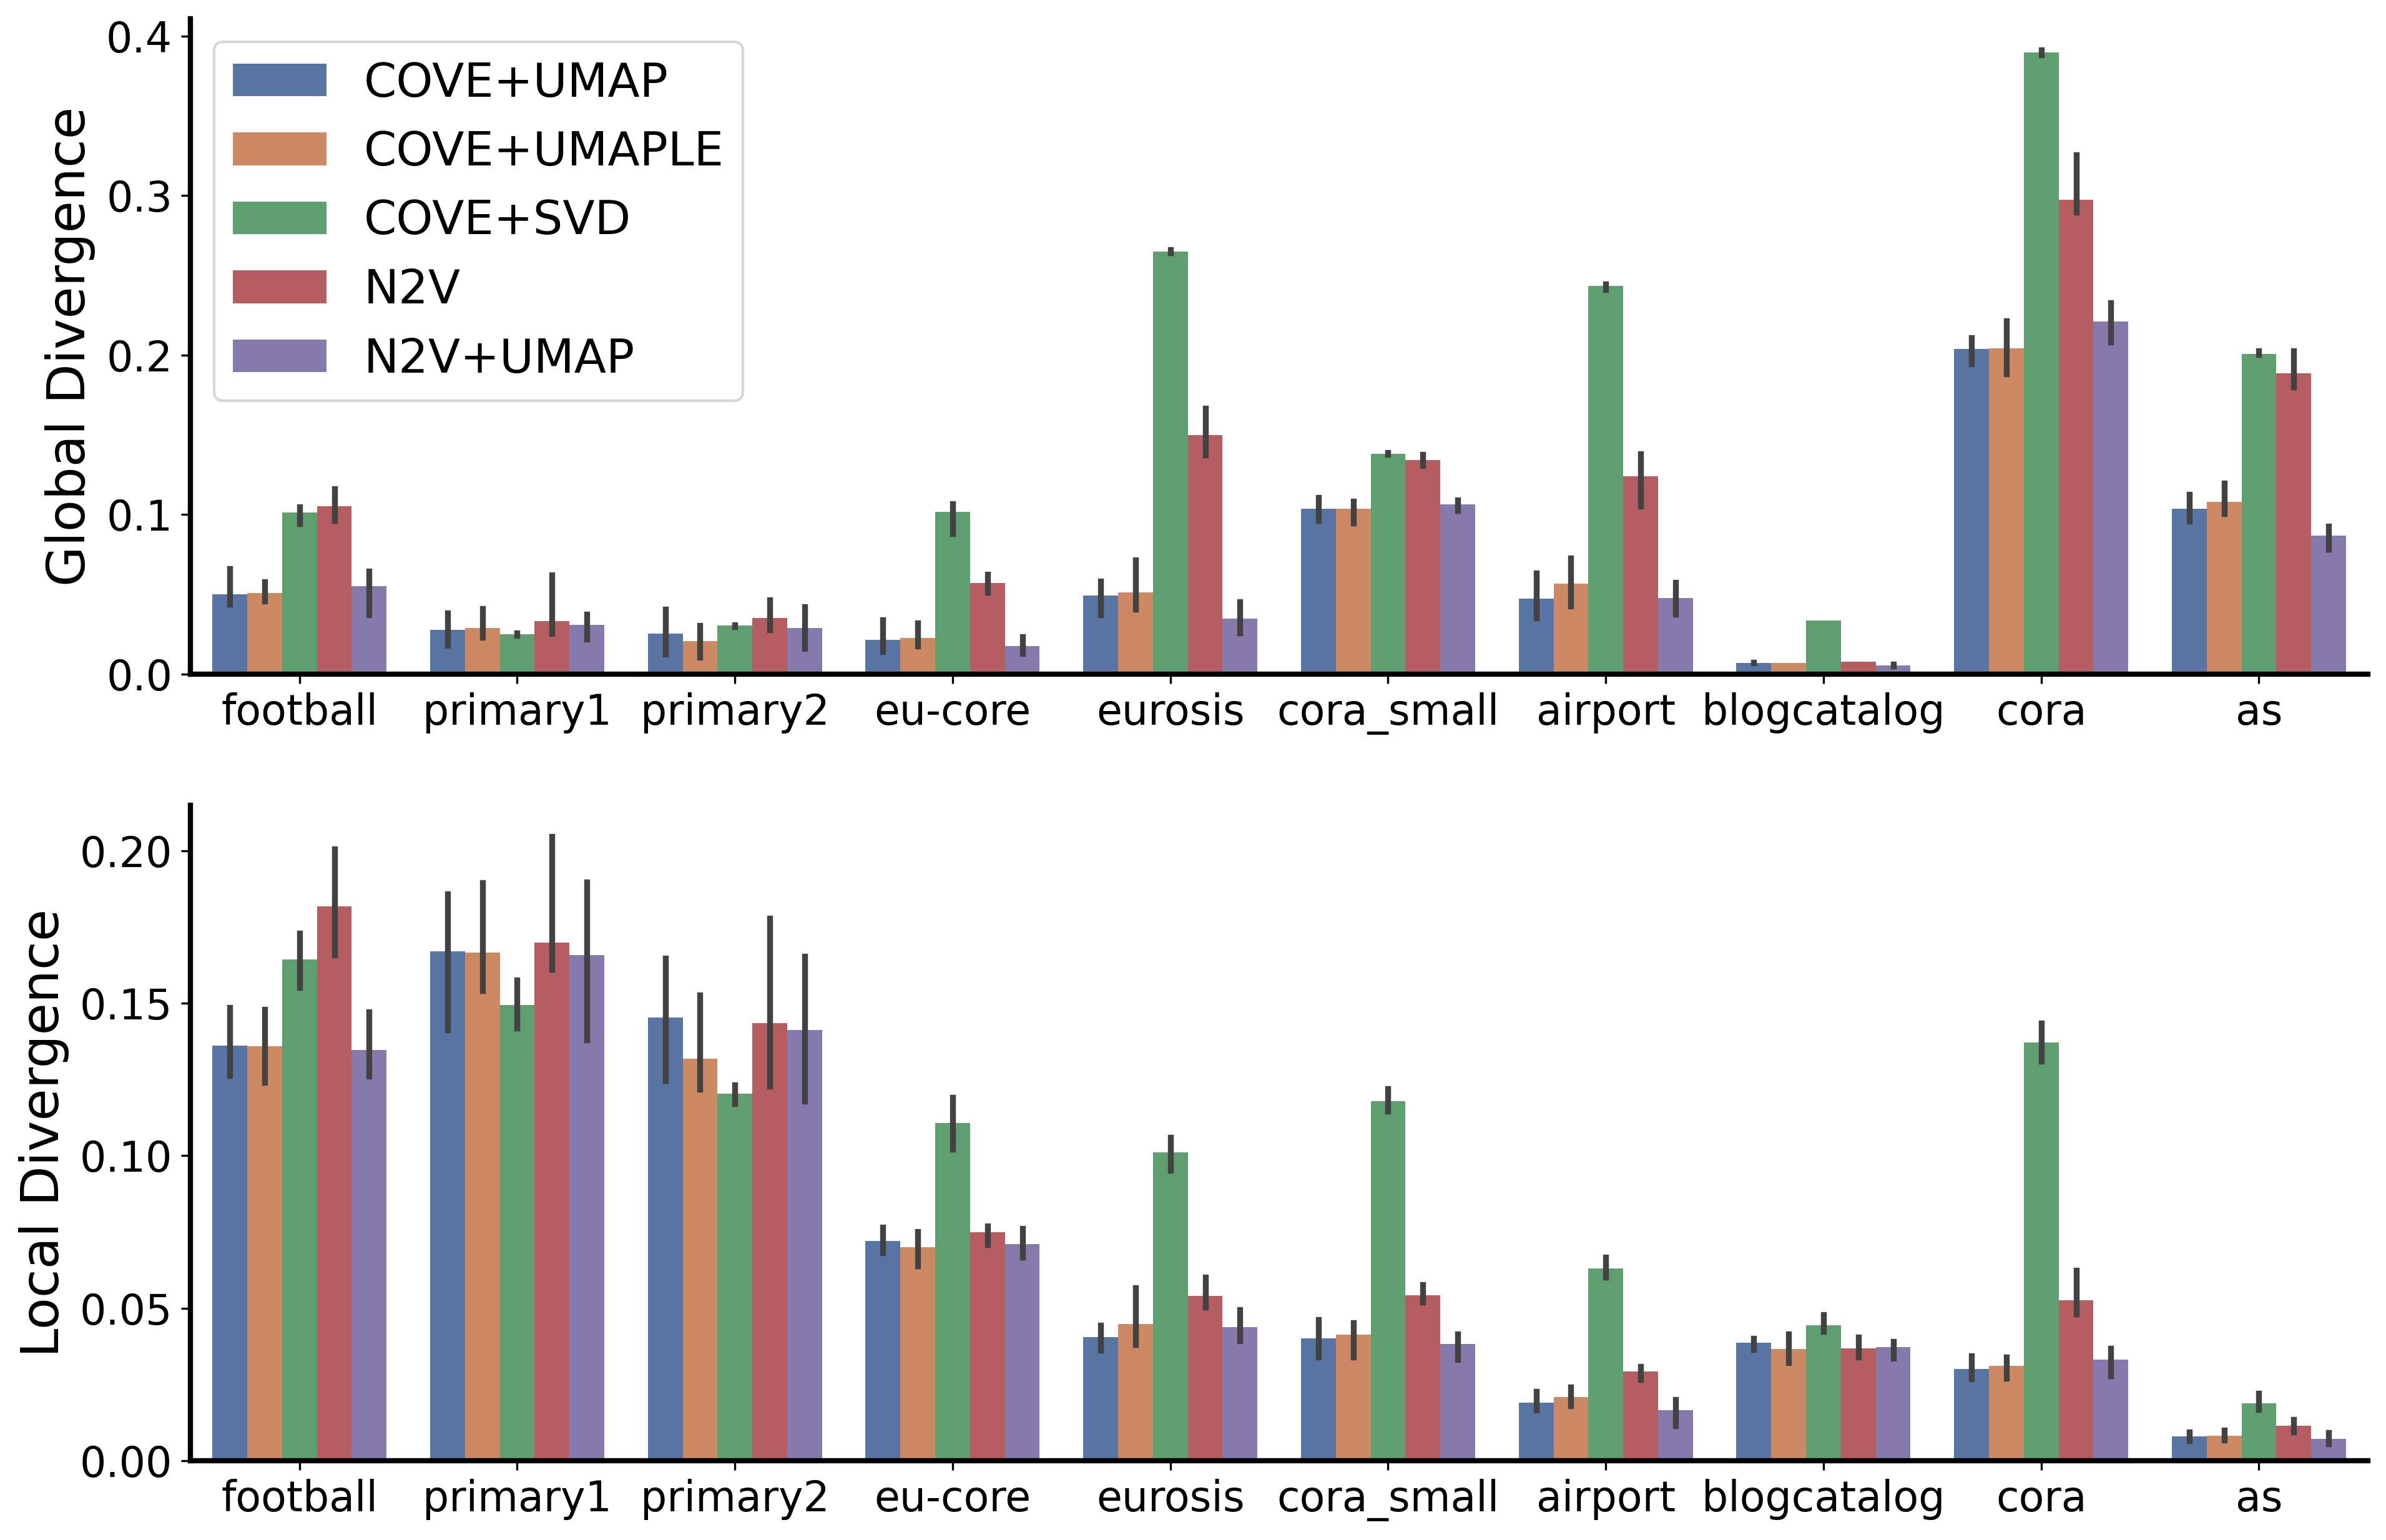

In [4]:
fig, axs = plt.subplots(2,1, figsize=(15,10), dpi=300)
sns.barplot(df, x="name", y="JS-Global", hue="method", ax=axs[0], palette="deep", legend=True, errorbar=("pi", 100))
axs[0].set_ylabel("Global Divergence", fontsize=20)

sns.barplot(df, x="name", y="JS-Local", hue="method", ax=axs[1], palette="deep", legend=False, errorbar=("pi", 100))
axs[1].set_ylabel("Local Divergence", fontsize=20)

for ax in axs:
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(2)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("")

axs[0].legend(fancybox=True, fontsize=18)

#fig.suptitle("Unsupervised Evaluation on Real Graphs", fontsize=25)
#plt.tight_layout(h_pad=5)